<a href="https://colab.research.google.com/github/leocorelli/ComputerVisionProject/blob/main/LogisticRegression_Car_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Classification of car models using non deep learning approach**.\
This notebook contains step by step guide on how to classify cars using logistic regression

Import Dependencies

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings("ignore")

Mount Google drive to access the data from the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Point to the folder where data has to be downloaded

In [ ]:
%cd /content/drive/MyDrive/computerVision

/content/drive/MyDrive/computerVision


Unzip the training data

In [ ]:
!unzip train_real.zip

Archive:  train_real.zip
replace train_real/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train_real/.DS_Store    
replace __MACOSX/train_real/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/train_real/._.DS_Store  
y


Unzip the testing data

In [ ]:
!unzip test_real.zip

Function to create custom pytorch datasets

In [ ]:
from torchvision.io import read_image
#from PIL import ImageFile
#ImageFile.LOAD_TRUNCATED_IMAGES = True

class CarsDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self,index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index,0])
    image = read_image(img_path)
    label = int(self.annotations.iloc[index,-1])
    
    if self.transform:
      image = self.transform(image)
    
    return image, label

Function to apply different tranformations

In [ ]:
from torchvision.transforms.transforms import ToPILImage
from torch.utils import data

data_transforms = {
    'train': transforms.Compose([      
        transforms.ToPILImage(),        
        #transforms.RandomResizedCrop(224),
        transforms.Resize(256),               # NOT IN ORIGINAL
        transforms.CenterCrop(224),           # NOT ORIGINAL
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([    
        transforms.ToPILImage(),                           
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Create the training and test data from the custom method and augment the data by applying the transformations

In [ ]:
train_dataset = CarsDataset('train_w_converted.txt','./train_real', data_transforms['train'])
val_dataset = CarsDataset('test_w_converted.txt','./test_real', data_transforms['val'])
dataset_sizes = {'train':len(train_dataset),'val':len(val_dataset)}

print(f'Length of train_dataset is: {len(train_dataset)}')
print(f'Length of val_dataset is: {len(val_dataset)}')

Length of train_dataset is: 16016
Length of val_dataset is: 14939


Create data loaders and split the data into batches

In [ ]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=16)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             shuffle=False, num_workers=16)

dataloaders = {'train':train_loader,'val':val_loader}

## Model

Now that we have prepared our data loaders, we can define our model.

* A **logistic regression** model is almost identical to a linear regression model. It contains weights and bias matrices, and the output is obtained using simple matrix operations (`pred = x @ w.t() + b`). 

* As we did with linear regression, we can use `nn.Linear` to create the model instead of manually creating and initializing the matrices.

* Since `nn.Linear` expects each training example to be a vector, each `3x224x224` image tensor is _flattened_ into a vector of size 150528 `(3*224*224)` before being passed into the model. 

* The output for each image is a vector of size 431, with each element signifying the probability of a particular target label. The predicted label for an image is simply the one with the highest probability.

In [ ]:
import torch.nn as nn

input_size = 3*224*224
num_classes = 431

# Logistic regression model
model = nn.Linear(input_size, num_classes)

In [ ]:
print(model.weight.shape)
model.weight

torch.Size([431, 150528])


Parameter containing:
tensor([[ 8.7692e-04, -1.5913e-03,  8.6228e-04,  ...,  8.6582e-05,
          2.4944e-03,  2.4818e-03],
        [ 4.5188e-04,  1.3916e-05, -7.4557e-04,  ..., -1.5437e-03,
         -1.1841e-03,  1.7061e-03],
        [-6.2313e-04,  1.9934e-03, -7.5949e-05,  ..., -1.1873e-03,
          2.1115e-03,  1.0491e-03],
        ...,
        [ 7.8408e-04,  1.4902e-03, -1.0784e-03,  ..., -1.3958e-03,
         -4.8483e-04, -1.4622e-03],
        [-8.3008e-04, -1.7341e-03,  1.7390e-03,  ...,  1.0937e-03,
          8.1005e-05,  5.8338e-04],
        [-2.5181e-04, -1.5469e-03, -1.7024e-03,  ..., -1.9968e-03,
          1.0928e-03,  2.0770e-03]], requires_grad=True)

In [ ]:
print(model.bias.shape)
model.bias

torch.Size([431])


Parameter containing:
tensor([-8.9636e-04, -4.0729e-04, -1.6041e-03,  2.2647e-03,  7.2139e-04,
        -4.3837e-04,  1.2266e-03,  1.8798e-03, -6.3372e-06,  4.8769e-04,
        -2.3492e-03, -2.5281e-03, -9.9846e-04, -4.9665e-05, -4.0633e-04,
         1.3262e-03, -3.7169e-04,  1.8727e-03, -1.6118e-03,  1.2323e-03,
        -8.3653e-04, -1.1722e-03,  1.1564e-03, -6.5791e-05,  2.3773e-03,
         1.2527e-05,  1.0489e-03,  1.4988e-03, -1.8062e-04, -1.7605e-03,
        -9.0189e-04,  1.7681e-03,  2.4089e-03,  1.1246e-03,  2.2029e-03,
         1.0369e-03,  1.4137e-03,  1.0499e-03,  3.3570e-04, -3.8545e-04,
         2.4597e-03, -3.5344e-04, -2.2720e-03, -7.8906e-04,  4.9216e-04,
         1.2074e-03, -2.1755e-03,  1.0935e-04, -1.2365e-03, -7.0296e-04,
         2.1764e-03, -6.5639e-04,  1.7697e-03, -1.1732e-04, -5.1099e-05,
         1.0304e-03,  2.4803e-03,  1.4888e-04,  3.3759e-04, -6.0497e-04,
        -6.6504e-04, -6.6975e-04, -1.5190e-03, -1.0370e-03,  1.5347e-03,
        -6.6784e-04, -1.2191e

Display the image

In [ ]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break

tensor([370,  30,  30, 122, 429, 348, 210, 278,  85, 411, 299, 246, 388, 167,
        175,  59, 208, 249, 333, 297, 210,  48,   9, 340, 314, 115, 360, 268,
        148,  68, 145, 287])
torch.Size([32, 3, 224, 224])


RuntimeError: ignored

In [ ]:
images.shape

torch.Size([32, 3, 224, 224])

In [ ]:
images.reshape(32, 150528).shape

torch.Size([32, 150528])

The code above leads to an error because our input data does not have the right shape. Our images are of the shape 3x28x28, but we need them to be vectors of size 150528, i.e., we need to flatten them. We'll use the `.reshape` method of a tensor, which will allow us to efficiently 'view' each image as a flat vector without really creating a copy of the underlying data. To include this additional functionality within our model, we need to define a custom model by extending the `nn.Module` class from PyTorch. 

Classes can also build upon or _extend_ the functionality of existing classes. Let's extend the `nn.Module` class from PyTorch to define a custom model.

In [ ]:
class CarModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 150528)
        out = self.linear(xb)
        return out
    
model = CarModel()

Inside the `__init__` constructor method, we instantiate the weights and biases using `nn.Linear`. And inside the `forward` method, which is invoked when we pass a batch of inputs to the model, we flatten the input tensor and pass it into `self.linear`.

`xb.reshape(-1, 150528)` indicates to PyTorch that we want a *view* of the `xb` tensor with two dimensions. The length along the 2nd dimension is 3\*224\*224 (i.e., 150528). One argument to `.reshape` can be set to `-1` (in this case, the first dimension) to let PyTorch figure it out automatically based on the shape of the original tensor.

Note that the model no longer has `.weight` and `.bias` attributes (as they are now inside the `.linear` attribute), but it does have a `.parameters` method that returns a list containing the weights and bias.

In [ ]:
model.linear

Linear(in_features=150528, out_features=431, bias=True)

In [ ]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([431, 150528]) torch.Size([431])


[Parameter containing:
 tensor([[-1.1880e-03,  2.5362e-03,  1.2352e-03,  ...,  1.4591e-03,
          -1.3256e-03,  5.2723e-04],
         [ 2.1849e-03, -1.8072e-03,  2.3635e-03,  ..., -6.5830e-05,
           3.6845e-04, -1.4525e-03],
         [-3.8058e-04,  1.5349e-03,  1.5801e-03,  ..., -2.0406e-03,
          -1.6218e-03,  1.0970e-03],
         ...,
         [-2.0083e-03, -1.7908e-03,  1.6512e-03,  ...,  1.4100e-03,
          -2.2152e-03, -1.6832e-03],
         [-2.3520e-03, -2.1258e-03, -8.2645e-04,  ..., -7.8081e-04,
           1.9652e-03, -2.3219e-03],
         [ 3.0959e-04,  1.7012e-03,  1.4480e-03,  ...,  8.2080e-04,
          -6.2446e-04, -1.0509e-03]], requires_grad=True),
 Parameter containing:
 tensor([-1.4708e-03, -2.4730e-03,  1.8678e-03, -7.8198e-04, -2.1158e-03,
         -2.5081e-03, -1.3739e-04, -1.9671e-03, -8.5683e-04,  1.2015e-03,
          2.0202e-03,  1.8313e-03,  1.2030e-03,  1.0304e-03,  1.1875e-03,
         -1.0873e-03, -2.4109e-03, -1.1949e-03,  7.9937e-05,  1.23

We can use our new custom model in the same way as before. Let's see if it works.

In [ ]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([32, 3, 224, 224])
outputs.shape :  torch.Size([32, 431])
Sample outputs :
 tensor([[-2.6649e-01, -5.9991e-03,  2.0771e-01, -3.7419e-01, -1.0610e-01,
         -7.0066e-01,  3.1469e-01, -1.9118e-01,  2.4316e-01,  2.5109e-02,
         -7.9865e-01, -7.0293e-02, -7.8035e-01,  2.6730e-01, -5.4691e-01,
         -1.6654e+00,  3.8568e-01, -3.0592e-01,  1.5885e+00, -2.1776e-01,
          4.8043e-01, -8.9693e-01,  6.2812e-01, -8.0487e-01,  2.4533e-01,
         -2.2773e-01, -4.9023e-01, -5.7397e-02, -7.1978e-02,  6.8417e-01,
          3.0468e-01, -2.2018e-01,  1.7091e-01, -4.3361e-01, -1.3614e-01,
         -5.2088e-01,  6.4118e-01, -5.3125e-01,  1.4665e+00,  1.5174e+00,
          9.7967e-01,  5.0859e-01, -6.6972e-01,  1.9123e-01,  5.3745e-01,
         -1.2128e-01,  7.6711e-02, -3.0778e-01, -4.6009e-02,  8.0425e-01,
         -3.7026e-01,  1.5258e-01, -1.3606e+00, -3.5183e-01,  5.1647e-01,
          1.1943e-01, -4.1414e-01, -1.8972e-01, -7.1182e-02,  4.3164e-01,
         -1.3351e+00, -6.

For each of the 100 input images, we get 431 outputs, one for each class. We'd like these outputs to represent probabilities. Each output row's elements must lie between 0 to 1 and add up to 1, which is not the case. 

To convert the output rows into probabilities, we use the softmax function, which has the following formula:

![softmax](https://i.imgur.com/EAh9jLN.png)

First, we replace each element `yi` in an output row by `e^yi`, making all the elements positive. 

![](https://www.montereyinstitute.org/courses/DevelopmentalMath/COURSE_TEXT2_RESOURCE/U18_L1_T1_text_final_6_files/image001.png)



Then, we divide them by their sum to ensure that they add up to 1. The resulting vector can thus be interpreted as probabilities.

While it's easy to implement the softmax function, we'll use the implementation that's provided within PyTorch because it works well with multidimensional tensors (a list of output rows in our case).

In [ ]:
import torch.nn.functional as F

The softmax function is included in the `torch.nn.functional` package and requires us to specify a dimension along which the function should be applied.

In [ ]:
outputs[:2]

tensor([[-2.6649e-01, -5.9991e-03,  2.0771e-01, -3.7419e-01, -1.0610e-01,
         -7.0066e-01,  3.1469e-01, -1.9118e-01,  2.4316e-01,  2.5109e-02,
         -7.9865e-01, -7.0293e-02, -7.8035e-01,  2.6730e-01, -5.4691e-01,
         -1.6654e+00,  3.8568e-01, -3.0592e-01,  1.5885e+00, -2.1776e-01,
          4.8043e-01, -8.9693e-01,  6.2812e-01, -8.0487e-01,  2.4533e-01,
         -2.2773e-01, -4.9023e-01, -5.7397e-02, -7.1978e-02,  6.8417e-01,
          3.0468e-01, -2.2018e-01,  1.7091e-01, -4.3361e-01, -1.3614e-01,
         -5.2088e-01,  6.4118e-01, -5.3125e-01,  1.4665e+00,  1.5174e+00,
          9.7967e-01,  5.0859e-01, -6.6972e-01,  1.9123e-01,  5.3745e-01,
         -1.2128e-01,  7.6711e-02, -3.0778e-01, -4.6009e-02,  8.0425e-01,
         -3.7026e-01,  1.5258e-01, -1.3606e+00, -3.5183e-01,  5.1647e-01,
          1.1943e-01, -4.1414e-01, -1.8972e-01, -7.1182e-02,  4.3164e-01,
         -1.3351e+00, -6.8693e-01,  1.0996e+00,  6.7960e-02, -9.8906e-02,
          6.6148e-01,  1.6139e-01,  1.

In [ ]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.0014, 0.0019, 0.0023, 0.0013, 0.0017, 0.0009, 0.0026, 0.0015, 0.0024,
         0.0019, 0.0008, 0.0017, 0.0009, 0.0024, 0.0011, 0.0004, 0.0027, 0.0014,
         0.0091, 0.0015, 0.0030, 0.0008, 0.0035, 0.0008, 0.0024, 0.0015, 0.0011,
         0.0018, 0.0017, 0.0037, 0.0025, 0.0015, 0.0022, 0.0012, 0.0016, 0.0011,
         0.0035, 0.0011, 0.0081, 0.0085, 0.0050, 0.0031, 0.0010, 0.0023, 0.0032,
         0.0017, 0.0020, 0.0014, 0.0018, 0.0042, 0.0013, 0.0022, 0.0005, 0.0013,
         0.0031, 0.0021, 0.0012, 0.0015, 0.0017, 0.0029, 0.0005, 0.0009, 0.0056,
         0.0020, 0.0017, 0.0036, 0.0022, 0.0021, 0.0012, 0.0024, 0.0061, 0.0010,
         0.0016, 0.0044, 0.0003, 0.0012, 0.0020, 0.0006, 0.0006, 0.0009, 0.0014,
         0.0020, 0.0024, 0.0052, 0.0035, 0.0011, 0.0039, 0.0043, 0.0035, 0.0005,
         0.0013, 0.0009, 0.0041, 0.0032, 0.0020, 0.0012, 0.0042, 0.0027, 0.0035,
         0.0017, 0.0017, 0.0047, 0.0029, 0.0011, 0.0047, 0.0016, 0.0009, 0.0014,
     

Finally, we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. We can do this using `torch.max`, which returns each row's largest element and the corresponding index.

In [ ]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([186, 393, 393, 287,  52, 267, 296,  54, 276, 386, 423, 340, 395, 389,
        216, 393, 208, 356,  18, 351, 221, 190,  95, 389, 157,  43, 200, 331,
        173, 227, 121, 108])
tensor([0.0135, 0.0251, 0.0188, 0.0180, 0.0088, 0.0173, 0.0169, 0.0142, 0.0106,
        0.0110, 0.0186, 0.0190, 0.0168, 0.0193, 0.0094, 0.0196, 0.0109, 0.0124,
        0.0153, 0.0147, 0.0147, 0.0127, 0.0106, 0.0163, 0.0179, 0.0125, 0.0172,
        0.0138, 0.0247, 0.0144, 0.0097, 0.0273], grad_fn=<MaxBackward0>)


In [ ]:
labels

tensor([137, 361, 200, 282,  70, 373, 396, 309,  59,  31,  54, 407, 220,  76,
         77, 135, 198, 322, 412, 226, 260, 127,  26, 313, 158, 152, 404, 420,
          4,  18, 184, 193])

**Evaluation Metric and Loss Function**

Just as with linear regression, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly, i.e,. the **accuracy** of the predictions. 

In [ ]:
outputs[:2]

tensor([[-2.6649e-01, -5.9991e-03,  2.0771e-01, -3.7419e-01, -1.0610e-01,
         -7.0066e-01,  3.1469e-01, -1.9118e-01,  2.4316e-01,  2.5109e-02,
         -7.9865e-01, -7.0293e-02, -7.8035e-01,  2.6730e-01, -5.4691e-01,
         -1.6654e+00,  3.8568e-01, -3.0592e-01,  1.5885e+00, -2.1776e-01,
          4.8043e-01, -8.9693e-01,  6.2812e-01, -8.0487e-01,  2.4533e-01,
         -2.2773e-01, -4.9023e-01, -5.7397e-02, -7.1978e-02,  6.8417e-01,
          3.0468e-01, -2.2018e-01,  1.7091e-01, -4.3361e-01, -1.3614e-01,
         -5.2088e-01,  6.4118e-01, -5.3125e-01,  1.4665e+00,  1.5174e+00,
          9.7967e-01,  5.0859e-01, -6.6972e-01,  1.9123e-01,  5.3745e-01,
         -1.2128e-01,  7.6711e-02, -3.0778e-01, -4.6009e-02,  8.0425e-01,
         -3.7026e-01,  1.5258e-01, -1.3606e+00, -3.5183e-01,  5.1647e-01,
          1.1943e-01, -4.1414e-01, -1.8972e-01, -7.1182e-02,  4.3164e-01,
         -1.3351e+00, -6.8693e-01,  1.0996e+00,  6.7960e-02, -9.8906e-02,
          6.6148e-01,  1.6139e-01,  1.

In [ ]:
torch.sum(preds == labels)

tensor(0)

In [ ]:
def accuracy(l1, l2):
    return torch.sum(l1, l2).item() / len(l1)

In [ ]:
accuracy1 = torch.sum(labels == preds) / len(labels)
accuracy2 = torch.sum(labels == preds).item() / len(labels)
print(accuracy1, "\n", accuracy2)

tensor(0.) 
 0.0


In [ ]:
print(outputs[:2], "\n", labels)

tensor([[-2.6649e-01, -5.9991e-03,  2.0771e-01, -3.7419e-01, -1.0610e-01,
         -7.0066e-01,  3.1469e-01, -1.9118e-01,  2.4316e-01,  2.5109e-02,
         -7.9865e-01, -7.0293e-02, -7.8035e-01,  2.6730e-01, -5.4691e-01,
         -1.6654e+00,  3.8568e-01, -3.0592e-01,  1.5885e+00, -2.1776e-01,
          4.8043e-01, -8.9693e-01,  6.2812e-01, -8.0487e-01,  2.4533e-01,
         -2.2773e-01, -4.9023e-01, -5.7397e-02, -7.1978e-02,  6.8417e-01,
          3.0468e-01, -2.2018e-01,  1.7091e-01, -4.3361e-01, -1.3614e-01,
         -5.2088e-01,  6.4118e-01, -5.3125e-01,  1.4665e+00,  1.5174e+00,
          9.7967e-01,  5.0859e-01, -6.6972e-01,  1.9123e-01,  5.3745e-01,
         -1.2128e-01,  7.6711e-02, -3.0778e-01, -4.6009e-02,  8.0425e-01,
         -3.7026e-01,  1.5258e-01, -1.3606e+00, -3.5183e-01,  5.1647e-01,
          1.1943e-01, -4.1414e-01, -1.8972e-01, -7.1182e-02,  4.3164e-01,
         -1.3351e+00, -6.8693e-01,  1.0996e+00,  6.7960e-02, -9.8906e-02,
          6.6148e-01,  1.6139e-01,  1.

In [ ]:
loss_fn = F.cross_entropy
loss = loss_fn(outputs, labels)
print(loss.item())

6.370771408081055


**Optimizer**

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

## Training the model

Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

Some parts of the training loop are specific the specific problem we're solving (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem. 

We'll include the problem-independent parts within a function called `fit`, which will be used to train the model. The problem-specific parts will be implemented by adding new methods to the `nn.Module` class.


In [ ]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    # Calculate Loss
    preds = model(xb)
    loss = loss_func(preds, yb)
    
    if opt is not None:
        # Compute Gradients
        loss.backward()
        # Update parameters
        opt.step()
        # Reset gradients
        opt.zero_grad()
    
    metric_result = None
    if metric is not None:
        # Compute the metric
        metric_result = metric(preds, yb)
    return loss.item(), len(xb), metric_result

In [ ]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():    # Gradient Descent is not needed for validation
        # Pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        # Separate losses, counts and metrics
        losses, batch_num, metrics = zip(*results)
        # Total size of dataset
        total_batch = np.sum(batch_num)
        # Average loss across batches
        avg_loss = np.sum(np.multiply(losses, batch_num)) / total_batch
        avg_metric = None
        if metric is not None:
            # Avg of metric across batches
            avg_metric = np.sum(np.multiply(metrics, batch_num)) / total_batch
    return avg_loss, total_batch, avg_metric

In [ ]:
def accuracy(outputs, labels):
    max_value, pred_idxs = torch.max(outputs, dim=1)
    return torch.sum(pred_idxs == labels).item() / len(labels)

In [ ]:
val_loss, total, val_acc = evaluate(model, loss_fn, val_loader, metric=accuracy)
print("Loss: {:.4f}, Accuracy: {:.4f}".format(val_loss, val_acc))

Loss: 6.3310, Accuracy: 0.0021


***We can now define the `fit()` function using `loss_batch()` and `evaluate()`.***

In [ ]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl, metric=None):
    accuracies = []
    for epoch in range(epochs):
        # Training
        for xb, yb in train_dl:
            loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)
        # Evaluation
        val_loss, total_batches, val_acc = evaluate(model, loss_fn, valid_dl, metric)
        accuracies.append(val_acc)
        # Printing the progresses
        if metric is None:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, val_loss))
        else:
            print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'
                          .format(epoch+1, epochs, val_loss, metric.__name__, val_acc))
            
    return accuracies

In [ ]:
# Redefining the model and optimizer
model = CarModel()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
loss_fn = F.cross_entropy

In [ ]:
accuracies = fit(5, model, loss_fn, optimizer, train_loader, val_loader, accuracy)
print(["{:.4f}".format(accur) for accur in accuracies])

Epoch [1/5], Loss: 8.2873, accuracy: 0.0172
Epoch [2/5], Loss: 9.6327, accuracy: 0.0140
Epoch [3/5], Loss: 8.0624, accuracy: 0.0293
Epoch [4/5], Loss: 8.3666, accuracy: 0.0256
Epoch [5/5], Loss: 9.1751, accuracy: 0.0251
['0.0172', '0.0140', '0.0293', '0.0256', '0.0251']


In [ ]:
for accuracy in accuracies:
    print("Accuracy: {:.4f}".format(accuracy))

Accuracy: 0.0172
Accuracy: 0.0140
Accuracy: 0.0293
Accuracy: 0.0256
Accuracy: 0.0251


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

While the accuracy does continue to increase as we train for more epochs, the improvements get smaller with every epoch. Let's visualize this using a line graph.

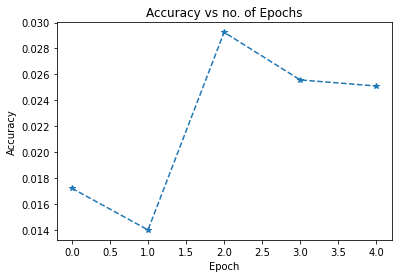

In [ ]:
plt.plot(accuracies, '--*')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy vs no. of Epochs");